# Mechanik – Ganz ohne schmutzige Hände

Dieses Jupyter-Notebook enthält den Quelltext für Kapitel 10 »Mechanik – Ganz ohne schmutzige Hände« im Buch [Python für Ingenieure für Dummies](https://python-fuer-ingenieure.de/).

In [1]:
# sorgt dafür, dass, wenn die letzte Zeile eine Zuweisung ist, deren Ergebnis auch ausgegeben wird
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [2]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np

import sys
sys.path.append("../util")
from pfi_util import define_plot_params, show_book, set_cmap_cycler

orig_plt_rcParams, double_plt_rcParams = define_plot_params(plt)
set_cmap_cycler(N=2)

### Statik und Festigkeitslehre (Lagerkräfte und Biegelienie)

`begin statik1`

In [3]:
# Notwendige Symbole erstellen (aus einem String)
FAh, FAv, FBv, FL, l1, l2, alpha = \
    sp.symbols("F_Ah, F_Av,  F_Bv, F_L, l1, l2, alpha")
#_
# Linke Seiten der Bilanzgleichungen ("equations")
# (rechte Seiten sind 0)
eqns = [
    FAh - FL*sp.cos(alpha),
    FAv + FBv - FL*sp.sin(alpha),
    -l1*FL*sp.sin(alpha) + l2*FBv
]
#_
sol_dict = sp.solve(eqns, [FAh, FAv, FBv])

{F_Ah: F_L*cos(alpha),
 F_Av: (-F_L*l1*sin(alpha) + F_L*l2*sin(alpha))/l2,
 F_Bv: F_L*l1*sin(alpha)/l2}

`end statik1`

In [4]:
# Lösung als LaTeX-Code ausgeben (fürs Buch)
print(sp.latex(sol_dict))

\left\{ F_{Ah} : F_{L} \cos{\left(\alpha \right)}, \  F_{Av} : \frac{- F_{L} l_{1} \sin{\left(\alpha \right)} + F_{L} l_{2} \sin{\left(\alpha \right)}}{l_{2}}, \  F_{Bv} : \frac{F_{L} l_{1} \sin{\left(\alpha \right)}}{l_{2}}\right\}


`begin balken1`

In [5]:
E, I, q0, l, x = sp.symbols("E, I, q0, l, x")

In [6]:
w = sp.Function("w")(x)

w(x)

In [7]:
sol = sp.dsolve(w.diff(x, 4) - q0/(E*I), w)
#_
# dsolve liefert ein `Equality`-Objekt
# relevant ist dessen rechte Seite
w_sol = sol.rhs

C1 + C2*x + C3*x**2 + C4*x**3 + q0*x**4/(24*E*I)

`end balken1`

`begin balken2`

In [8]:
w_sol.subs([("C1", 0), ("C2", 0)])

C3*x**2 + C4*x**3 + q0*x**4/(24*E*I)

`end balken2`

`begin balken3`

In [9]:
# Randbedingungen: linke Seiten der vier
# "lhs=0"-Gleichungen in einer Liste anordnen
eqns = [
    w_sol.subs(x, 0),
    w_sol.diff(x).subs(x, 0),
    w_sol.diff(x, 2).subs(x, l),
    w_sol.diff(x, 3).subs(x, l),    
]


[C1, C2, 2*C3 + 6*C4*l + l**2*q0/(2*E*I), 6*C4 + l*q0/(E*I)]

In [10]:
sol_dict = sp.solve(eqns, ["C1", "C2", "C3", "C4"])

{C1: 0, C2: 0, C3: l**2*q0/(4*E*I), C4: -l*q0/(6*E*I)}

`end balken3`

`begin balken4`

In [11]:
# numerische Parameter einsetzen
b, h = 0.2, 0.04  # Breite, Dicke [m]
Enum = 10*1e9  # Elastizitätsmodul (Holz) [N/m**2]
q0num = 100  # konstante Streckenlast [N/m]
Inum = b*h**3/12  # Flächenträgheitsmoment
lnum = 5  # [m]
#_
param_values = [(E, Enum), (I, Inum), (q0, q0num), (l, lnum)]
w_sol_num = w_sol.subs(sol_dict).subs(param_values)

0.000390625*x**4 - 0.0078125*x**3 + 0.05859375*x**2

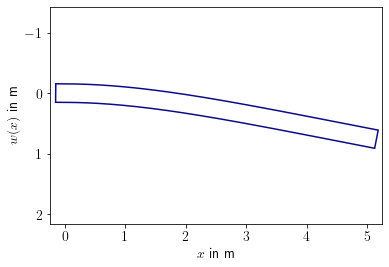

In [12]:
# zum Plotten umwandeln in aufrufbare Funktion
w_func = sp.lambdify(x, w_sol_num, modules="numpy")
#_
xx = np.linspace(0, lnum, 1000)
ww = w_func(xx)  # numerische Auswertung der Biegelinie
plt.plot(xx, ww, lw=20) # dicke dunkle Linie
plt.plot(xx, ww, lw=17, color="white") # etwas dünner, weiß
plt.gca().invert_yaxis() # damit positiv unten ist
plt.axis("equal") # gleicher Maßstab in x- und y-Richtung
# #!
plt.xlabel("$x$ in m") #!
plt.ylabel(r"$w(x)$ in m") #!
show_book("eingespannter_balken") #!

`end balken4`

In [13]:
# Einfach-Integral über die Variable x
# in den Grenzen von 0 bis x
# (mathematisch nicht ganz sauber, aber
# sympy weiß wie es gemeint ist)

sp.integrate(q0, (x, 0, x))

q0*x

In [14]:

# Vierfach-Integral nach dem gleichen Muster

sp.integrate(q0, x, x, x, x)

q0*x**4/24

`begin rotationsmatrix`

In [15]:
def R(phi):
    """
    Rotationsmatrix in der Ebene
    """
    c = sp.cos(phi)
    s = sp.sin(phi)
       
    return  sp.Matrix([[c, -s], [s, c]])
    
R("theta1") # Rotationsmatrix

Matrix([
[cos(theta1), -sin(theta1)],
[sin(theta1),  cos(theta1)]])

`end rotationsmatrix`

## Kinematik (Beispiel: Viergelenkgetriebe)

`begin kinematik1`

In [16]:
# Einheitsvektoren in x- und y-Richtung
ex = sp.Matrix([1, 0]) 
ey = sp.Matrix([0, 1]) 
#_
# Symbole für die Winkel definieren
theta1, theta2, theta3 = ttheta = sp.symbols("theta1:4")
#_
# Längen der Glieder
l1, l2, l3, l4 = 0.3, 0.6, 0.7, 0.9

`end kinematik1`

Geometrie der offenen kinematischen Kette

`begin kinematik2`

In [17]:
# Basis 1 und 2
B1 = sp.Matrix([0, 0])
B2 = sp.Matrix([l4, 0])
#_
G1 = B1 + R(theta1)*ex*l1
G2 = G1 + R(theta1 + theta2)*ex*l2
#_
# Ende der offenen Kette
E = G2 + R(theta1 + theta2 + theta3)*ex*l3
#_
# Zusammenfassen der Koord. aller Punkte in einer Matrix
# (später fürs Plotten benötigt)
joints = sp.Matrix.hstack(B1, G1, G2, E, B2)
#_
# Kettenschlussbedingung (2 skalare Gleichungen)
constraints = sp.Matrix([E - B2])
pass #!

`end kinematik2`

In [18]:
# nicht direkt im Buch, um ungerenderten LaTeX-Code in Ausgabe zu vermeiden
# stattdessen wird der LaTeX-Code in das Buch-Dokument kopiert.

`begin kinematik3`

In [19]:
#!print(sp.latex(sp.Eq(constraints, sp.Matrix([0, 0]))))

`end kinematik3`

In [20]:
print(sp.latex(sp.Eq(constraints, sp.Matrix([0, 0])) ))

\left[\begin{matrix}0.3 \cos{\left(\theta_{1} \right)} + 0.6 \cos{\left(\theta_{1} + \theta_{2} \right)} + 0.7 \cos{\left(\theta_{1} + \theta_{2} + \theta_{3} \right)} - 0.9\\0.3 \sin{\left(\theta_{1} \right)} + 0.6 \sin{\left(\theta_{1} + \theta_{2} \right)} + 0.7 \sin{\left(\theta_{1} + \theta_{2} + \theta_{3} \right)}\end{matrix}\right] = \left[\begin{matrix}0\\0\end{matrix}\right]


`begin kinematik4`

In [21]:
# Umwandeln symb. Ausdrücke in aufrufbare Funktionen
c_func = sp.lambdify(ttheta, constraints, modules="numpy")

<function _lambdifygenerated(theta1, theta2, theta3)>

`end kinematik4`

`begin kinematik5`

In [22]:
# Zielfunktion für Minimierung
def target_func(X, theta1):    
    # "Kettenschluss-Fehlervektor":
    err = c_func(theta1, X[0], X[1])
    return err[0]**2 + err[1]**2

`end kinematik5`

`begin kinematik6`

In [23]:
# isolierter Test der Nebenbedingungen u. Minimierung
from scipy.optimize import fmin
#_
# Startwert und zugehörige -schätzung (0, 0)
ttheta0 = [0.25*np.pi, 0, 0]
#_
# Auswertung des Fehlervektors
err = c_func(*ttheta0)

array([[0.23137085],
       [1.13137085]])

In [24]:
#_
# Zielfunktion (Betragsquadrat von err)
target_func(ttheta0[1:], ttheta0[0])

array([1.33353247])

`end kinematik6`

`begin kinematik7`

In [25]:
# Test der Minimierung
res = fmin(target_func, x0=ttheta0[1:], args=(ttheta0[0],))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 82
         Function evaluations: 149


array([-2.18923901,  1.97689051])

`end kinematik7`

In [26]:
set_cmap_cycler(3)

`begin kinematik8`

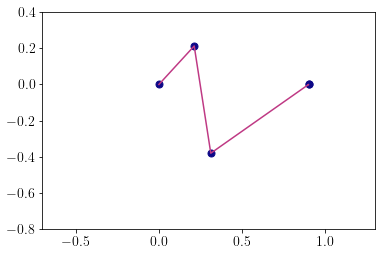

In [27]:
# isolierter Test des Plottens
# Umwandeln symb. Ausdrücke in aufrufbare Funktionen
j_func = sp.lambdify(ttheta, joints, modules="numpy")
#_
# Auswerten -> Array mit shape=(2, 5)
jc = joint_coords = j_func(ttheta0[0], *res)
#_
plt.plot(jc[0, :], jc[1, :], "o", ms=7) # dunkle Kreise, Größe 7
plt.plot(jc[0, :], jc[1, :], "-") # helle linien
#_
plt.axis([-0.7, 1.3, -0.8, 0.4])
show_book("viergelenk_plot1") #!

`end kinematik8`

Test der Minimierung mit anderer Startschätzung

In [28]:
# Test der Minimierung mit anderer Startschätzung

res = fmin(target_func, x0=[0, -2], args=(ttheta0[0],))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 86


array([ 0.02016544, -1.97692043])

(-0.5, 1.4, -0.4, 0.9)

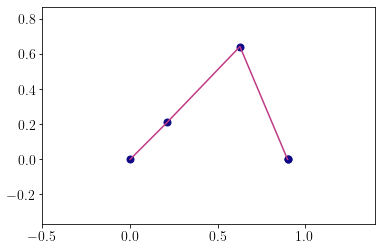

In [29]:
jc = joint_coords = j_func(ttheta0[0], *res)

plt.plot(jc[0, :], jc[1, :], "o", ms=7) # schw. Kreise, Größe 7
plt.plot(jc[0, :], jc[1, :], "-") # blaue linien

plt.axis("equal") # gleiche Skalierung für beide Achsen
plt.axis([-0.5, 1.4, -0.4, 0.9])

---

In der statischen (im Web abrufbaren) Version des Notebooks ist das folgende interaktive Widget zum manuellen verändern der Konfiguration des Viergelenkgetriebes nicht enthalten. Um es zu aktivieren muss das Notebook auf einem Notebook-Server ausgeführt werden, siehe Kapitel 2 »Installation und Inbetriebnahme«.

`begin kinematik9`

In [30]:
# Interaktion zwischen Optimierung und Gleichungslösung
from ipywidgets import interact

@interact(theta1num=(0, 7, 0.2)) # (min, max, step)
def plot_func(theta1num):
    res = fmin(target_func, x0=[0, 0], args=(theta1num,), disp=0)
    # disp=0 deaktiviert die Statusausgaben von fmin
    
    # das wird ein Array mit shape=(2, 5)
    jc = j_func(theta1num, *res) # Gelenkkoord. (joint coords)

    plt.plot(jc[0, :], jc[1, :], "o", ms=7)
    plt.plot(jc[0, :], jc[1, :], "-")  
    plt.axis("equal")
    plt.axis([-0.7, 1.3, -0.8, 0.4])
interact_fname = "viergelenk_interact" #!
show_book(interact_fname, saveandshow=False) #!

interactive(children=(FloatSlider(value=3.0, description='theta1num', max=7.0, step=0.2), Output()), _dom_clas…

`end kinematik9`

In [31]:
# Erzeugung kommt nicht ins Buch, Grafik schon
# Zwiebelschalen-Grafik (Anpassung der Alpha-Werte)

In [32]:
set_cmap_cycler(2, end=0.4)

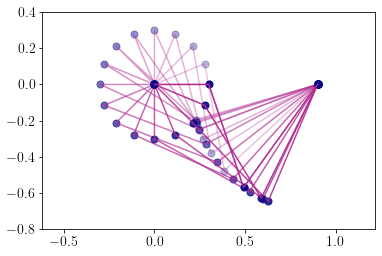

In [33]:
N = 17
theta1_values = np.linspace(0, 2, N)*np.pi
alpha_values = np.linspace(0.5, 1, N)


def plot_func(theta1num, alpha):
    res = fmin(target_func, x0=[0, 0], args=(theta1num,), disp=0)

    # das wird ein array mit shape=(2, 5)
    jc = joint_coords = j_func(theta1num, *res)

    plt.plot(jc[0, :], jc[1, :], "o", ms=7, alpha=alpha)
    plt.plot(jc[0, :], jc[1, :], "-", alpha=alpha)  
    plt.axis("equal")
    plt.axis([-0.7, 1.3, -0.8, 0.4])


# gemeinsam über theta1-Werte und alpha-Werte iteriern
for theta1num, alpha in zip(theta1_values[::1], alpha_values):
    plot_func(theta1num, alpha**2)

show_book(interact_fname, saveandshow=True) #!

In [34]:
theta1num = np.pi/4

0.7853981633974483

`begin kinematik10`

In [35]:
assert target_func(res, theta1num) < 1e-5

`end kinematik10`

Koppelkurve

`begin kinematik11`

In [36]:
# Erinnerung: G1 = B1 + R(theta1)*ex*l1

kx, ky = 0.25, 0.45

# Hilfspunkt (für verständlichere Visualisierung)
H = G1 + R(theta1 + theta2)*ex*kx
# Betrachteter Punkt auf der Koppel (mit ey ⊥ ex):
K = H + R(theta1 + theta2)*ey*ky

k_func = sp.lambdify(ttheta, K, modules="numpy")

N = 40
theta1_values = np.linspace(0, 2, N)*np.pi
KK = []
for theta1num in theta1_values:
    res = fmin(target_func, x0=[0, 0], args=(theta1num,), disp=0)
    KK.append(k_func(theta1num, *res))
# plotten (ausgeblendet)
koppelkurve_fname = "viergelenk_koppelkurve" #!
show_book(koppelkurve_fname, saveandshow=False) #!

`end kinematik11`

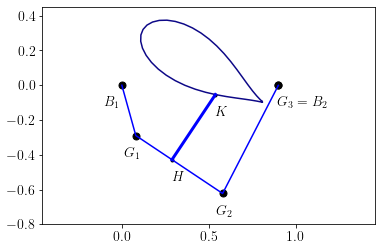

In [37]:
h_func = sp.lambdify(ttheta, H, modules="numpy")

# list -> array (shape: 2 x N)
KK = np.column_stack(KK)

plt.plot(KK[0, :], KK[1, :])


theta1num = -1.3
res = fmin(target_func, x0=[0, 0], args=(theta1num,), disp=0)
jc = joint_coords = j_func(theta1num, *res)
hc = h_func(theta1num, *res)
kc = k_func(theta1num, *res)

hkc = np.column_stack([hc, kc])


plt.plot(hkc[0, :], hkc[1, :], "ko", ms=3)  # graue Sechsecke

plt.plot(jc[0, :], jc[1, :], "ko", ms=7) # schw. Kreise, Größe 7
plt.plot(jc[0, :], jc[1, :], "b-") # blaue linien
plt.plot(hkc[0, :], hkc[1, :], "b-", lw=3) # blaue linien

dy = -.12
plt.text(hc[0, :], hc[1, :]+dy, "$H$")
plt.text(kc[0, :], kc[1, :]+dy, "$K$")


txt = ["$B_1$", "$G_1$", "$G_2$", "$G_3=B_2$", ""]
for i, arr in enumerate(jc.T):
    plt.text(arr[:1] -.1+.03*i , arr[1:] + dy, txt[i])


plt.axis("equal")
plt.axis([-0.5, 1.5, -0.8, 0.45])
show_book(koppelkurve_fname, saveandshow=True)

### Dynamik – Lagrange-Gleichungen 2. Art (Beispiel: Dreifachpendel)

`begin lagrange1`

In [38]:
s1, s2, m1, m2, l1, l2, g, t = \
                sp.symbols("s1, s2, m1, m2, l1, l2, g, t")

In [39]:
# Gelenkwinkel (= Relativwinkel)
# angelegt als Zeitfunktionen (und nicht als Symbol),
# damit später die totale Zeitableitung d/dt anwendbar ist
theta1 = sp.Function("theta1")(t)
theta2 = sp.Function("theta2")(t)
#_
# Einheitsvektor in y-Richtung
ey = sp.Matrix([0, 1])
#_
# Koordinatenursprung
O = sp.Matrix([0, 0]) 
#_
# Schwerpunkt1:
S1 = O + R(theta1)*(-ey)*s1
#_
# Gelenk1: 
G1 = O + R(theta1)*(-ey)*l1
#_
# Schwerpunkt2:
S2 = G1 + R(theta1+theta2)*(-ey)*s2
#_
# Gelenk2 (nur für grafische Darstellung): 
G2 = G1 + R(theta1+theta2)*(-ey)*l2
pass #!

`end lagrange1`

`begin lagrange2`

In [40]:
# potenzielle Energie (unnormiert)
V_tmp = m1*g*S1[1] + m2*g*S2[1]
#_
# normieren, sodass V >= 0
V = V_tmp - V_tmp.subs([(theta1, 0), (theta2, 0)])
pass #!

`end lagrange2`

`begin lagrange3`

In [41]:
# Schwerpunktsgeschwindigkeiten
S1d = S1.diff(t)
S2d = S2.diff(t)
#_
# kinetische Energie
T_tmp = m1/2*S1d.T*S1d + m2/2*S2d.T*S2d
#_
# Umwandeln: 1x1-Matrix -> skalarer Ausdruck
T = T_tmp[0, 0]
pass #!

`end lagrange3`

`begin lagrange4`

In [42]:
# Lagrange-Funktion
L = T - V
print(L.count_ops())

94


`end lagrange4`

`begin lagrange5`

In [43]:
thetadot1 = theta1.diff(t)
thetadot2 = theta2.diff(t)
#_
alpha1 = L.diff(thetadot1)
alpha2 = L.diff(thetadot2)
#_
beta1 = alpha1.diff(t)
beta2 = alpha2.diff(t)
#_
gamma1 = L.diff(theta1)
gamma2 = L.diff(theta2)
pass #!

`end lagrange5`

`begin lagrange6`

In [44]:
# Zusammenfassen der "equations of motion"
ee = sp.Matrix([beta1 - gamma1, beta2 - gamma2])
ee.applyfunc(sp.count_ops)

Matrix([
[145],
[101]])

`end lagrange6`

`begin lagrange7`

In [45]:
# Beschleunigungen
thetaddot1 = thetadot1.diff(t)
thetaddot2 = thetadot2.diff(t)
pass #!

In [46]:
# Massenmatrix
M = ee.jacobian([thetaddot1, thetaddot2])
M.applyfunc(sp.count_ops)

Matrix([
[61, 39],
[33, 17]])

In [47]:
# Vektor der Coriolis- und Zentrifugalterme
C = ee.subs([(thetaddot1, 0), (thetaddot2, 0), (g, 0)])
C.applyfunc(sp.count_ops)

Matrix([
[70],
[56]])

In [48]:
# Vektor Potenzialterme (bzw. alles was übrig bleibt)
K = ee - M*sp.Matrix([thetaddot1, thetaddot2]) - C
K.simplify()
K.applyfunc(sp.count_ops)

Matrix([
[17],
[ 7]])

`end lagrange7`

`begin lagrange8`

In [49]:
# Plausibilitätsprüfung:
# Potenzialterme müssen für g = 0 verschwinden
K.subs(g, 0)

Matrix([
[0],
[0]])

`end lagrange8`

`begin lagrange9`

In [50]:
ffbar = M.inv()*(-C-K)
ffbar.applyfunc(sp.count_ops)

Matrix([
[403],
[482]])

`end lagrange9`

`begin lagrange10`

In [51]:
# Zustand einführen
x1, x2, x3, x4 = xx = sp.symbols("x1:5")
#_
# Funktionen und Ableitungen ersetzen
replacements = [(theta1, x1), (theta2, x2),
                (thetadot1, x3), (thetadot2, x4)]

[(theta1(t), x1),
 (theta2(t), x2),
 (Derivative(theta1(t), t), x3),
 (Derivative(theta2(t), t), x4)]

In [52]:
# Umkehrung, damit Derivative-Objekte zuerst ersetzt werden
replacements.reverse()
ffbar_s = ffbar.subs(replacements)
ffbar_s.applyfunc(sp.count_ops)

Matrix([
[289],
[358]])

`end lagrange10`

Interessant, aber zu detailliert fürs Buch

`begin lagrange10-subsreihenfolge`

In [53]:
test = theta1 + 2*thetadot1 + 3*thetaddot1

theta1(t) + 2*Derivative(theta1(t), t) + 3*Derivative(theta1(t), (t, 2))

In [54]:
test_s_falsch = test.subs([(theta1, x1), (thetadot1, x3), (thetaddot1, sp.Symbol("z"))])

x1 + 2*Derivative(x1, t) + 3*Derivative(x1, (t, 2))

In [55]:
# Auswertung der Ableitungen nach t
test_s_falsch.doit()

x1

In [56]:
test_s_richtig = test.subs([(thetaddot1, sp.Symbol("z")), (thetadot1, x3), (theta1, x1)])

x1 + 2*x3 + 3*z

`end lagrange10-subsreihenfolge`

`begin lagrange11`

In [57]:
ff = sp.Matrix([x3, x4]).col_join(ffbar_s)
ff.applyfunc(sp.count_ops).T # .T, um Platz zu sparen

Matrix([[0, 0, 289, 358]])

`end lagrange11`

`begin lagrange12`

In [58]:
# Substitution der Systemparameter
param_values = [(g, 9.81), (l1, 1), (l2, 1),
                (s1, 0.8), (s2, 0.6), (m1, 0.5), (m2, 0.3)]
#_
ffnum = ff.subs(param_values)
ffnum.applyfunc(sp.count_ops).T # .T um Platz zu sparen

Matrix([[0, 0, 197, 219]])

In [59]:
# Plausibilitätsprüfung: es dürfen nur noch 
# die Zustandskomponenten als Symbole auftreten
ffnum.atoms(sp.Symbol)

{x1, x2, x3, x4}

In [60]:
#_
# Umwandeln in ausführbare Funktion
ff_func = sp.lambdify(xx, list(ffnum), modules="numpy")

<function _lambdifygenerated(x1, x2, x3, x4)>

In [61]:
#_
# Test der Funktion mit "zufälligen" Werten
ff_func(1, 2, 3, 4) 

[3, 4, 1.843345725633971, -16.511615105822568]

`end lagrange12`

`begin lagrange13`

In [62]:
def rhs(t, xx):
    # "right hand side" von xxdot = f(xx)
    # t wird ignoriert
    # Zustand xx wird entpackt
    return ff_func(*xx)
#_
# Festlegung eines Anfangszustands
xx0 = np.array([np.pi*0.8, -np.pi*0.2, 0, 0])
#_
# Test der rhs-Funktion für Anfangszustand
rhs(0, xx0)

[0.0, 0.0, -4.18252408101756, -5.7276948588654335]

`end lagrange13`

`begin lagrange14`

In [63]:
from scipy.integrate import solve_ivp
#_
tt = np.linspace(0, 10, 1000)
# maximale Schrittweite begrenzen für bessere Genauigkeit
res = solve_ivp(rhs, (0, tt[-1]), xx0, t_eval=tt, max_step=0.01)
pass #!

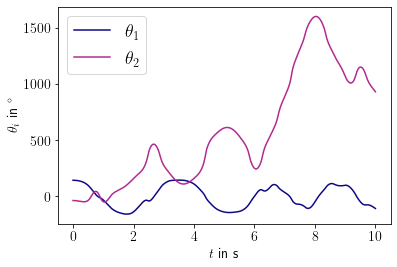

In [64]:
plt.plot(res.t, res.y[0, :]/np.pi*180, label=r"$\theta_1$")
plt.plot(res.t, res.y[1, :]/np.pi*180, label=r"$\theta_2$")
plt.legend()
plt.xlabel("$t$ in s") #!
plt.ylabel(r"$\theta_i$ in ${}^\circ$") #!
show_book("doppelpendel_ttheta_von_t") #!

`end lagrange14`

`begin lagrange15`

In [65]:
Eges = (T+V).subs(param_values+replacements)
Eges_func = sp.lambdify(xx, Eges)
pass #!

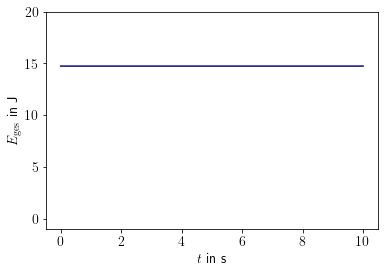

In [66]:
plt.plot(tt, Eges_func(*res.y))
plt.ylim(-1, 20) #!
plt.xlabel("$t$ in s") #!
plt.ylabel(r"$E_\mathrm{ges}$ in J") #!
show_book("Eges_von_t") #!

`end lagrange15`

Länger simulieren für 3D-Darstellung (nicht im Buch, aber trotzdem interessant)

In [67]:
tt = np.linspace(0, 100, 10000)
res = solve_ivp(rhs, (0, tt[-1]),  xx0*0.71, t_eval=tt, max_step=0.01)
pass # Leere Anweisung um unerwünschte Ausgabe am Zellenende zu vermeiden

In [68]:
N = 300

XX = np.row_stack([res.y[0, :-N*2], res.y[0, N:-N], res.y[0, 2*N:]])

array([[ 1.78442463e+00,  1.78387538e+00,  1.78222684e+00, ...,
        -5.79338034e-01, -6.17624723e-01, -6.56288350e-01],
       [ 1.17289627e+00,  1.13105256e+00,  1.08843179e+00, ...,
        -1.74623187e+00, -1.75850104e+00, -1.76963436e+00],
       [ 2.00315958e-02, -1.72050342e-03, -2.53005521e-02, ...,
        -1.55189887e+00, -1.52714647e+00, -1.50104159e+00]])

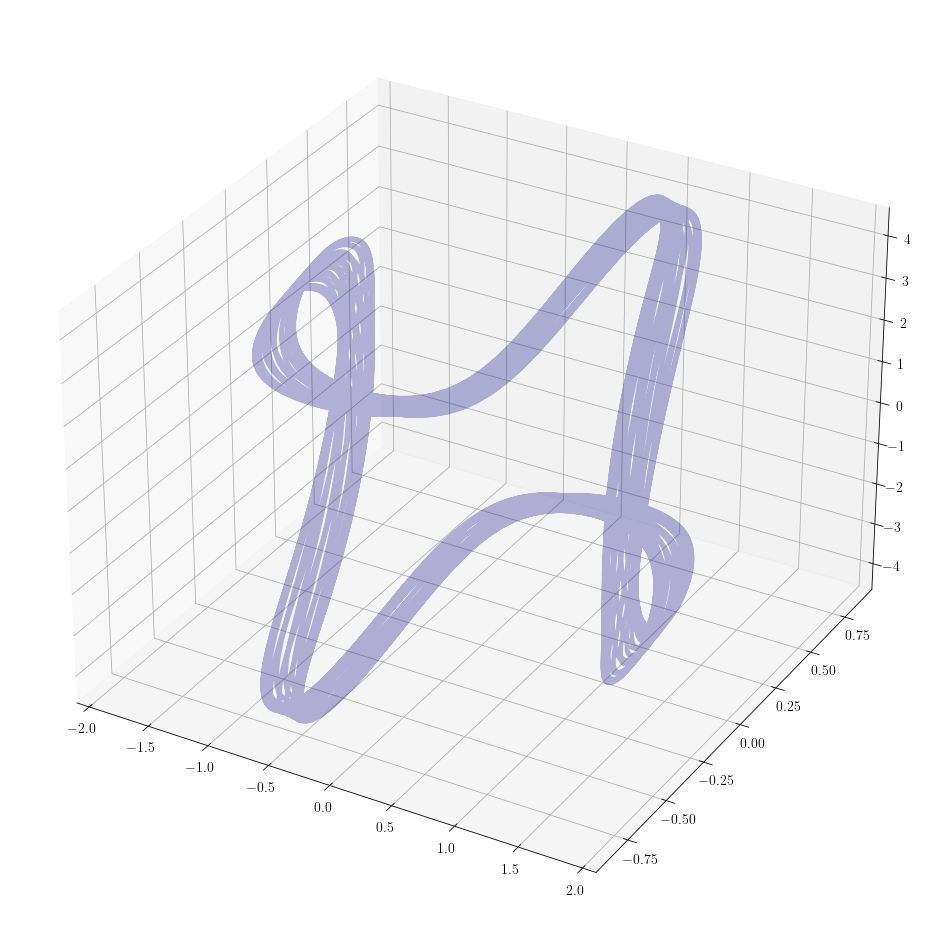

In [69]:
fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(111, projection='3d')

ax.plot(res.y[0, :], res.y[1, :], res.y[2, :], lw=3, alpha=0.3)
# ax.plot(XX[0, :], XX[1, :], XX[2, :], lw=3)

(-1.0, 20.0)

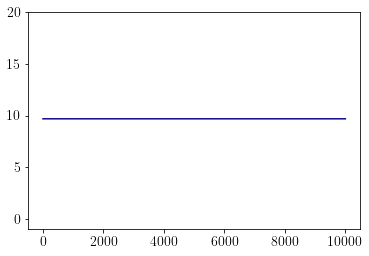

In [70]:
# Energieerhaltung überprüfen (nicht erfüllt, wenn Schrittweite zu groß ist!)

plt.plot(Eges_func(*res.y))
plt.ylim(-1, 20)